#  OOP Class for Normalizing & Visualizing Reviews

In [12]:
!pip install pandas matplotlib seaborn wordcloud nltk

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
import re
import warnings

nltk.download('vader_lexicon')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

class ReviewTextAnalyzer:
    def __init__(self, path):
        self.path = path
        self.df = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def load_and_clean(self):
        self.df = pd.read_csv(self.path)
        print(f"✅ Loaded {len(self.df)} records")

        self.df = self.df[['review', 'rating', 'date', 'bank', 'source']]
        self.df.drop_duplicates(inplace=True)
        self.df.dropna(subset=['review', 'rating', 'date', 'bank'], inplace=True)

        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce').dt.date
        self.df.dropna(subset=['date'], inplace=True)

    def show_missing_values(self):
        print("\n🕳️ Missing Values Summary:")
        missing = self.df.isnull().sum()
        total = len(self.df)
        for col, count in missing.items():
            if count > 0:
                percent = (count / total) * 100
                print(f" - {col}: {count} missing ({percent:.2f}%)")
        if missing.sum() == 0:
            print("✅ No missing values detected.")

    def show_rows_with_missing(self):
        rows_with_na = self.df[self.df.isnull().any(axis=1)]
        if len(rows_with_na) == 0:
            print("✅ No rows with missing values.")
        else:
            print(f"\n🔎 {len(rows_with_na)} rows have missing values:")
            print(rows_with_na.head())

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r"http\S+|[^a-z\s]", "", text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        return " ".join(tokens)

    def analyze_sentiment(self):
        self.df['clean_review'] = self.df['review'].astype(str).apply(self.preprocess_text)

        def get_sentiment(text):
            score = self.sentiment_analyzer.polarity_scores(text)
            return 'positive' if score['compound'] > 0.2 else 'negative' if score['compound'] < -0.2 else 'neutral'

        self.df['sentiment'] = self.df['clean_review'].apply(get_sentiment)

    def show_summary_statistics(self, bank=None):
        data = self.df[self.df['bank'] == bank] if bank else self.df
        label = f"Bank: {bank}" if bank else "All Banks"

        print(f"\n📌 --- Summary for {label} ---")
        print(f"Total Reviews: {len(data)}")
        print(f"Average Rating: {data['rating'].mean():.2f}")
        print(f"Max Review Length: {data['review'].astype(str).apply(len).max()}")
        print("Reviews per Day (Mean):", data.groupby('date').size().mean())

        print("Sentiment Breakdown:")
        print(data['sentiment'].value_counts())
        print("─────────────────────────────")

    def plot_sentiment_distribution(self, bank=None):
        data = self.df[self.df['bank'] == bank] if bank else self.df
        label = bank if bank else "All Banks"

        plt.figure(figsize=(10, 4))
        sns.countplot(data=data, x='sentiment', palette='coolwarm')
        plt.title(f"Sentiment Distribution - {label}")
        plt.xlabel("Sentiment")
        plt.ylabel("Number of Reviews")
        plt.tight_layout()
        plt.show()

        print(f"\n📊 Sentiment breakdown for {label} displayed above.\n")

    def plot_review_trend(self, bank=None):
        data = self.df[self.df['bank'] == bank] if bank else self.df
        label = bank if bank else "All Banks"

        plt.figure(figsize=(12, 5))
        grouped = data.groupby(['date']).size().reset_index(name='count')
        sns.lineplot(data=grouped, x='date', y='count', marker='o')
        plt.title(f"Review Trend Over Time - {label}")
        plt.xlabel("Date")
        plt.ylabel("Number of Reviews")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\n📈 Review trend over time for {label}.\n")

    def generate_word_cloud(self, bank=None):
        reviews = self.df[self.df['bank'] == bank]['clean_review'] if bank else self.df['clean_review']
        title = f"Word Cloud - {bank}" if bank else "Word Cloud - All Banks"
        text = " ".join(reviews.dropna())

        wc = WordCloud(width=1600, height=500, background_color='white').generate(text)
        plt.figure(figsize=(18, 6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=20)
        plt.tight_layout()
        plt.show()

        print(f"\n☁️ The word cloud above shows key themes in reviews for {bank if bank else 'all banks'}.\n")

    def show_frequent_words(self, bank=None, top_n=15):
        reviews = self.df[self.df['bank'] == bank]['clean_review'] if bank else self.df['clean_review']
        label = f"{bank}" if bank else "All Banks"
        text = " ".join(reviews.dropna())
        words = text.split()
        freq = Counter(words).most_common(top_n)
        words, counts = zip(*freq)

        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(counts), y=list(words), palette='viridis')
        plt.title(f"Top {top_n} Words - {label}")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.tight_layout()
        plt.show()

        print(f"\n📌 Top {top_n} most frequent words in reviews from {label}.\n")

    def analyze_all_banks(self):
        all_banks = sorted(self.df['bank'].unique())

        print(f"\n🔎 Found {len(all_banks)} banks: {', '.join(all_banks)}\n")

        for bank in all_banks:
            self.show_summary_statistics(bank)
            self.plot_sentiment_distribution(bank)
            self.plot_review_trend(bank)
            self.generate_word_cloud(bank)
            self.show_frequent_words(bank)

        print("\n✅ Completed detailed analysis for all banks.\n")

    def analyze_overall(self):
        print("\n📊 --- Overall Dataset Analysis ---")
        self.show_summary_statistics()
        self.plot_sentiment_distribution()
        self.plot_review_trend()
        self.generate_word_cloud()
        self.show_frequent_words()

    def run_full_analysis(self):
        self.load_and_clean()
        self.analyze_sentiment()
        self.analyze_overall()
        self.analyze_all_banks()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Getting the data from google drive

from google.colab import drive
#drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Loaded 8889 records

🕳️ Missing Values Summary:
✅ No missing values detected.
✅ No rows with missing values.
✅ Loaded 8889 records

📊 --- Overall Dataset Analysis ---

📌 --- Summary for All Banks ---
Total Reviews: 8882
Average Rating: 3.95
Max Review Length: 563
Reviews per Day (Mean): 4.754817987152034
Sentiment Breakdown:
sentiment
positive    5532
neutral     2606
negative     744
Name: count, dtype: int64
─────────────────────────────


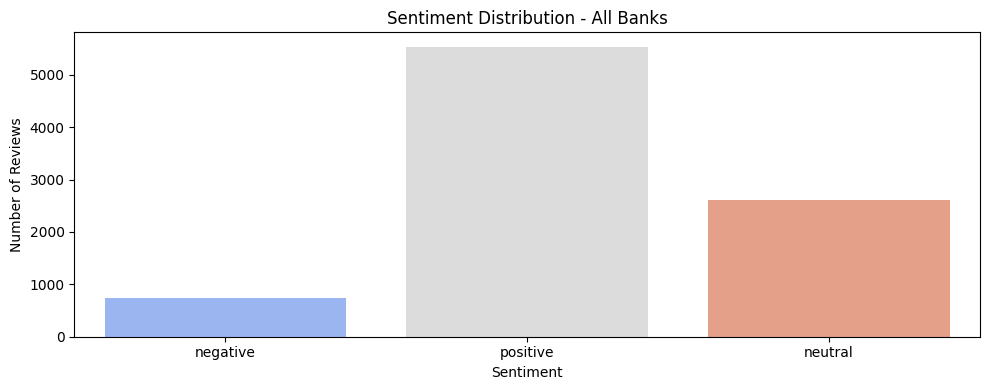


📊 Sentiment breakdown for All Banks displayed above.



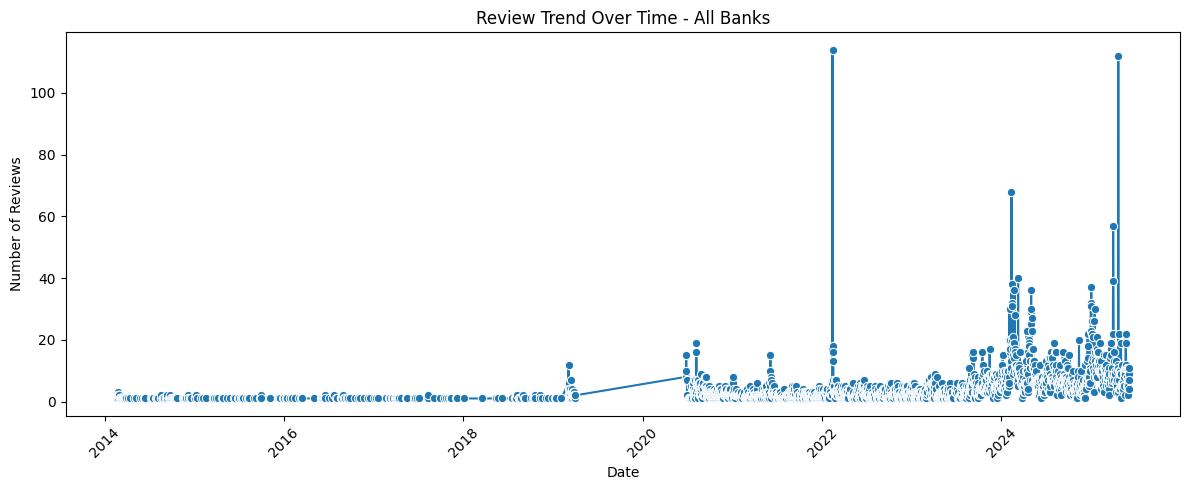


📈 Review trend over time for All Banks.



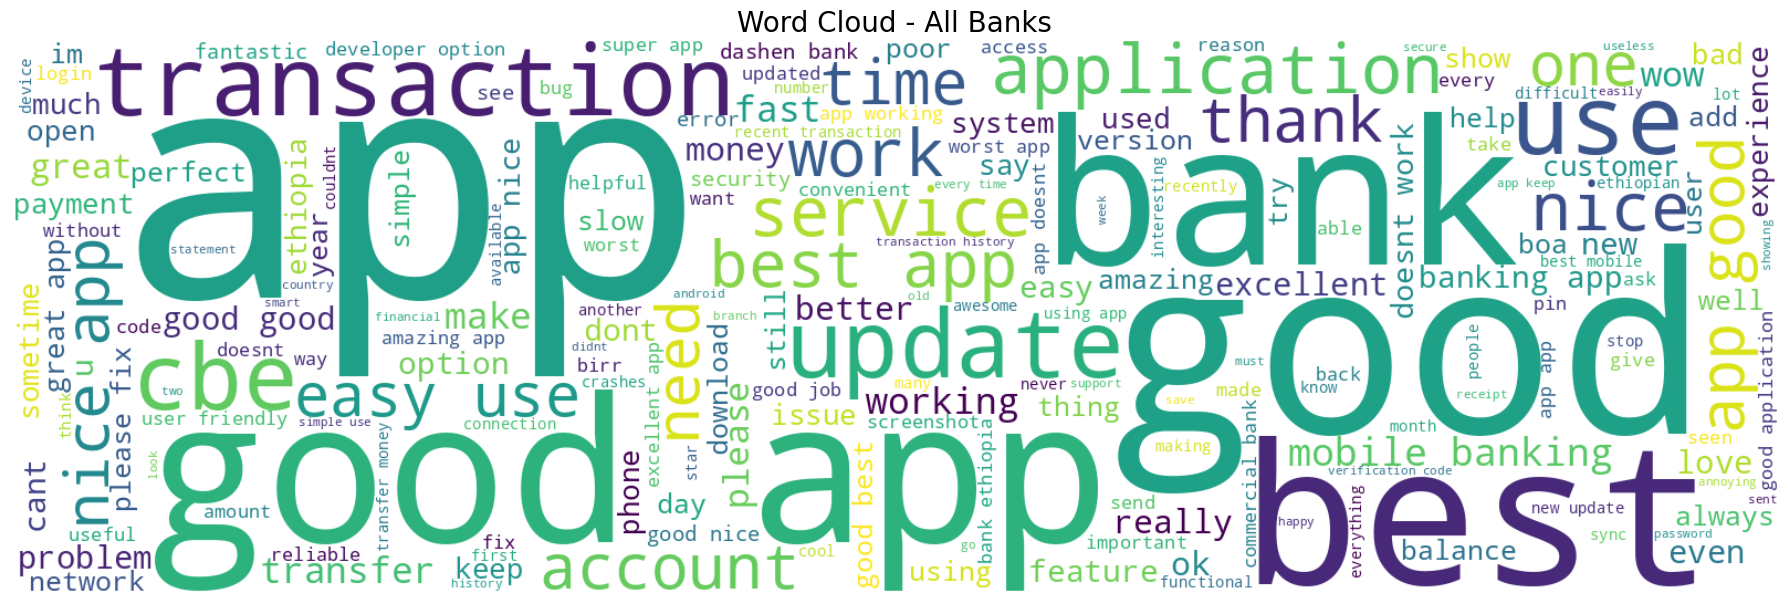


☁️ The word cloud above shows key themes in reviews for all banks.



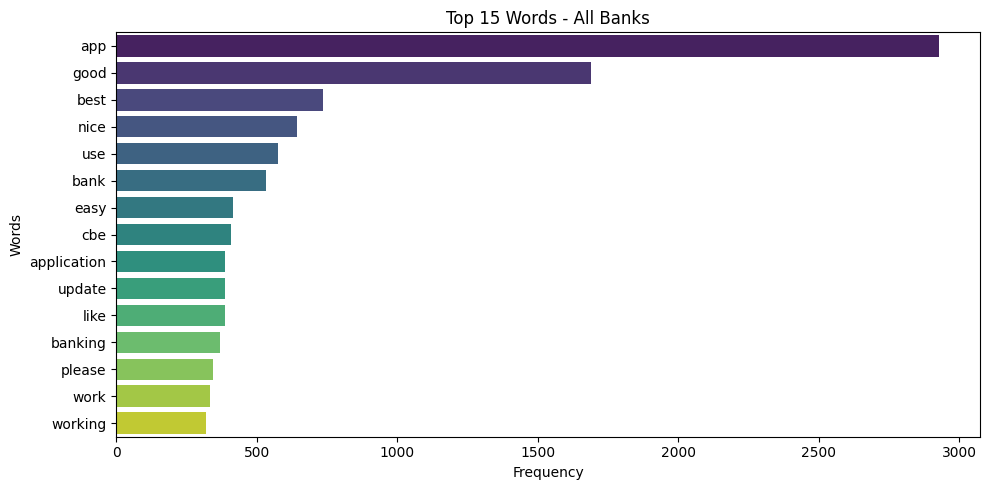


📌 Top 15 most frequent words in reviews from All Banks.


🔎 Found 3 banks: BOA, CBE, Dashen


📌 --- Summary for Bank: BOA ---
Total Reviews: 1045
Average Rating: 3.07
Max Review Length: 500
Reviews per Day (Mean): 2.7645502645502646
Sentiment Breakdown:
sentiment
positive    488
neutral     355
negative    202
Name: count, dtype: int64
─────────────────────────────


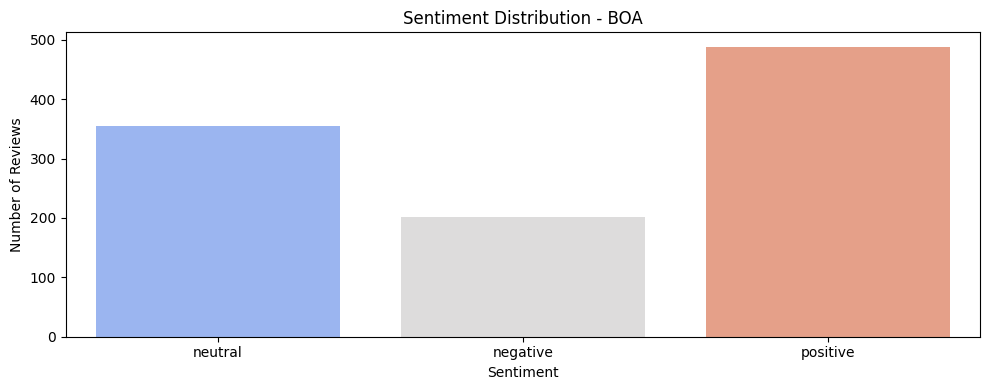


📊 Sentiment breakdown for BOA displayed above.



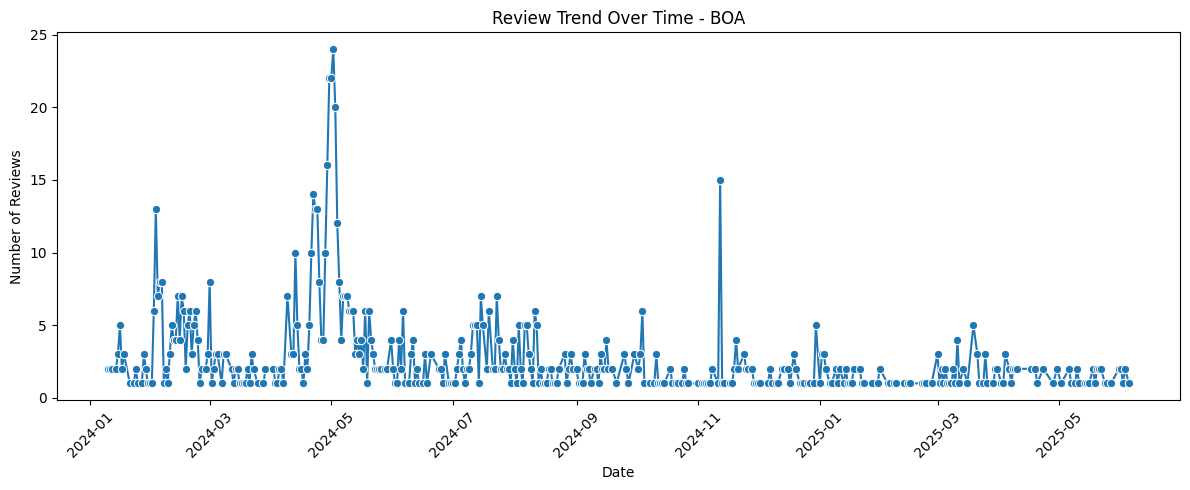


📈 Review trend over time for BOA.



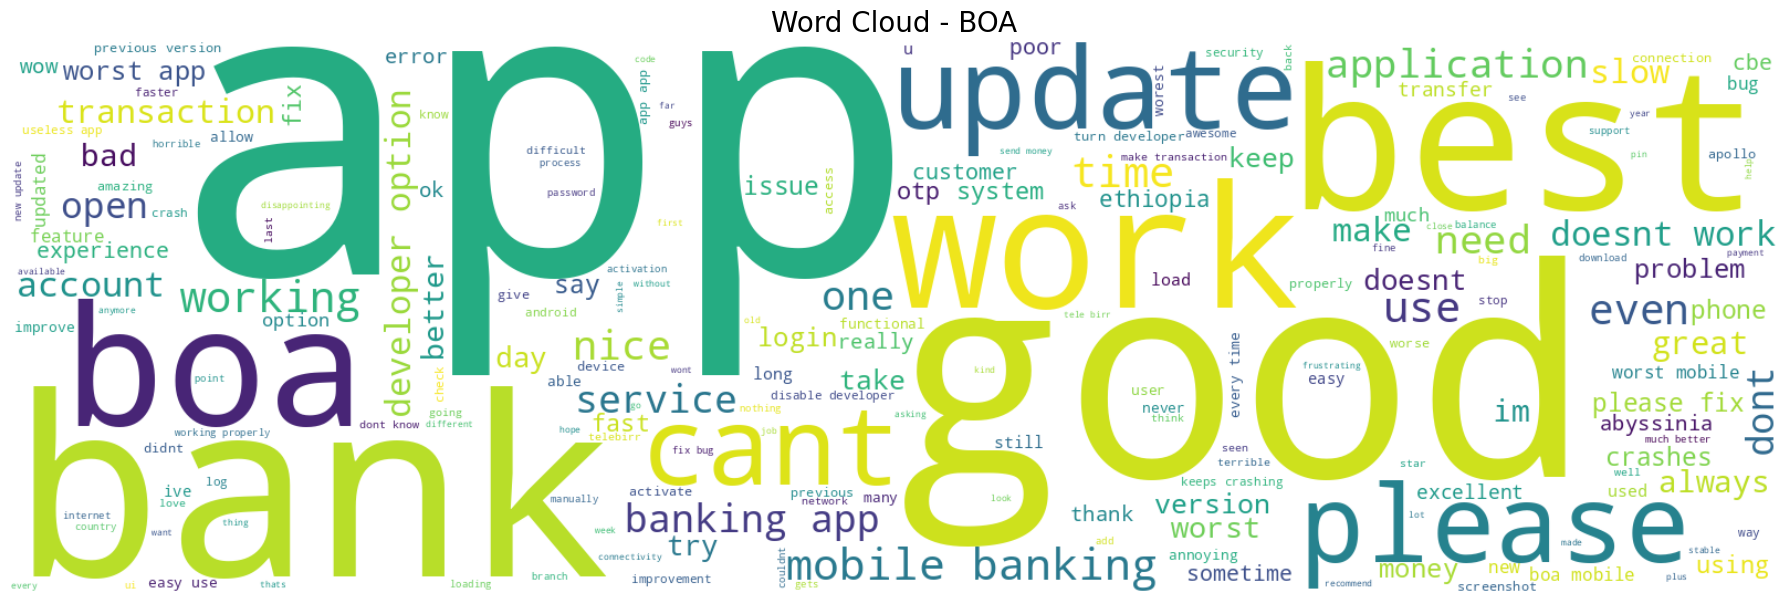


☁️ The word cloud above shows key themes in reviews for BOA.



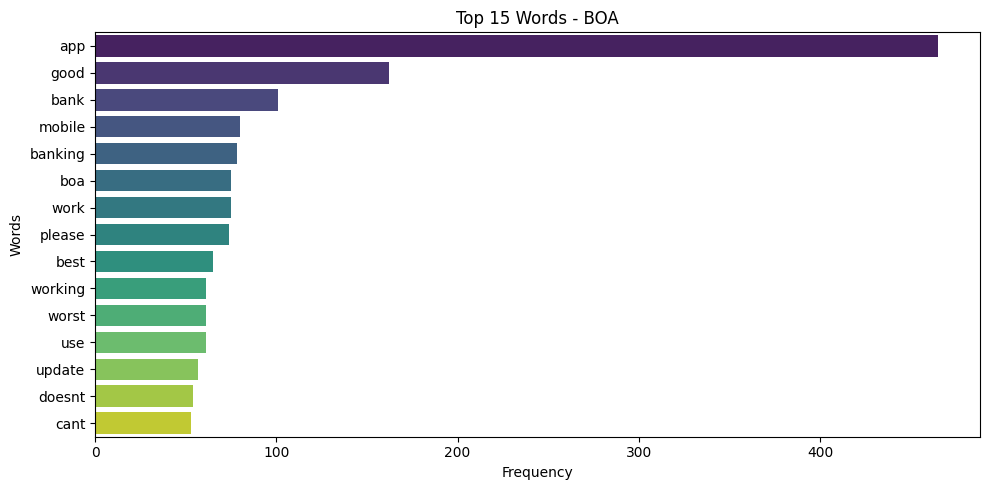


📌 Top 15 most frequent words in reviews from BOA.


📌 --- Summary for Bank: CBE ---
Total Reviews: 7389
Average Rating: 4.04
Max Review Length: 563
Reviews per Day (Mean): 3.9725806451612904
Sentiment Breakdown:
sentiment
positive    4711
neutral     2153
negative     525
Name: count, dtype: int64
─────────────────────────────


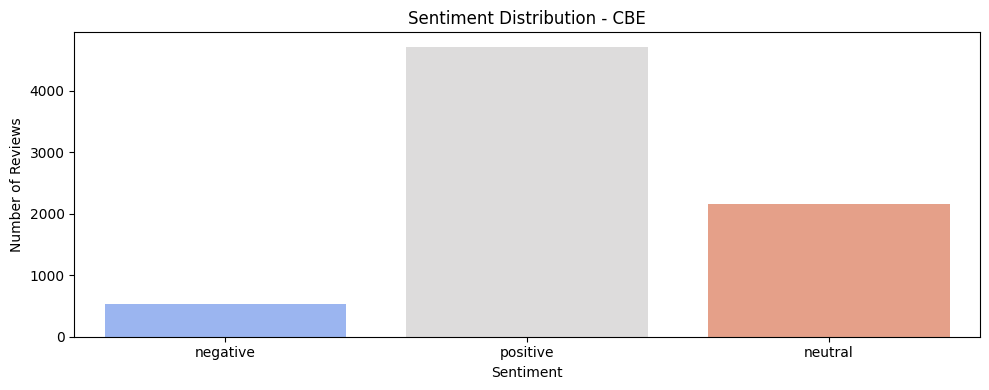


📊 Sentiment breakdown for CBE displayed above.



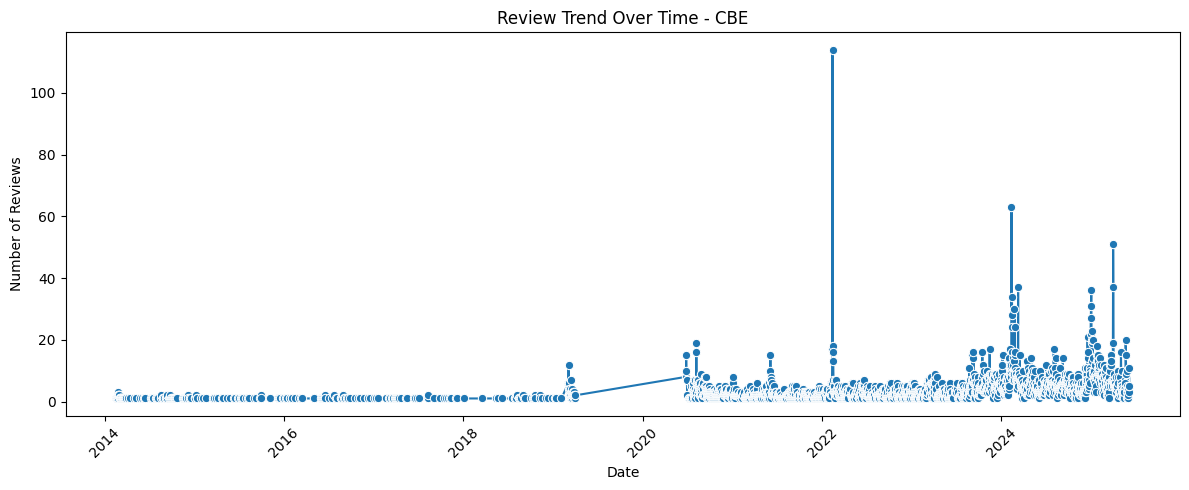


📈 Review trend over time for CBE.



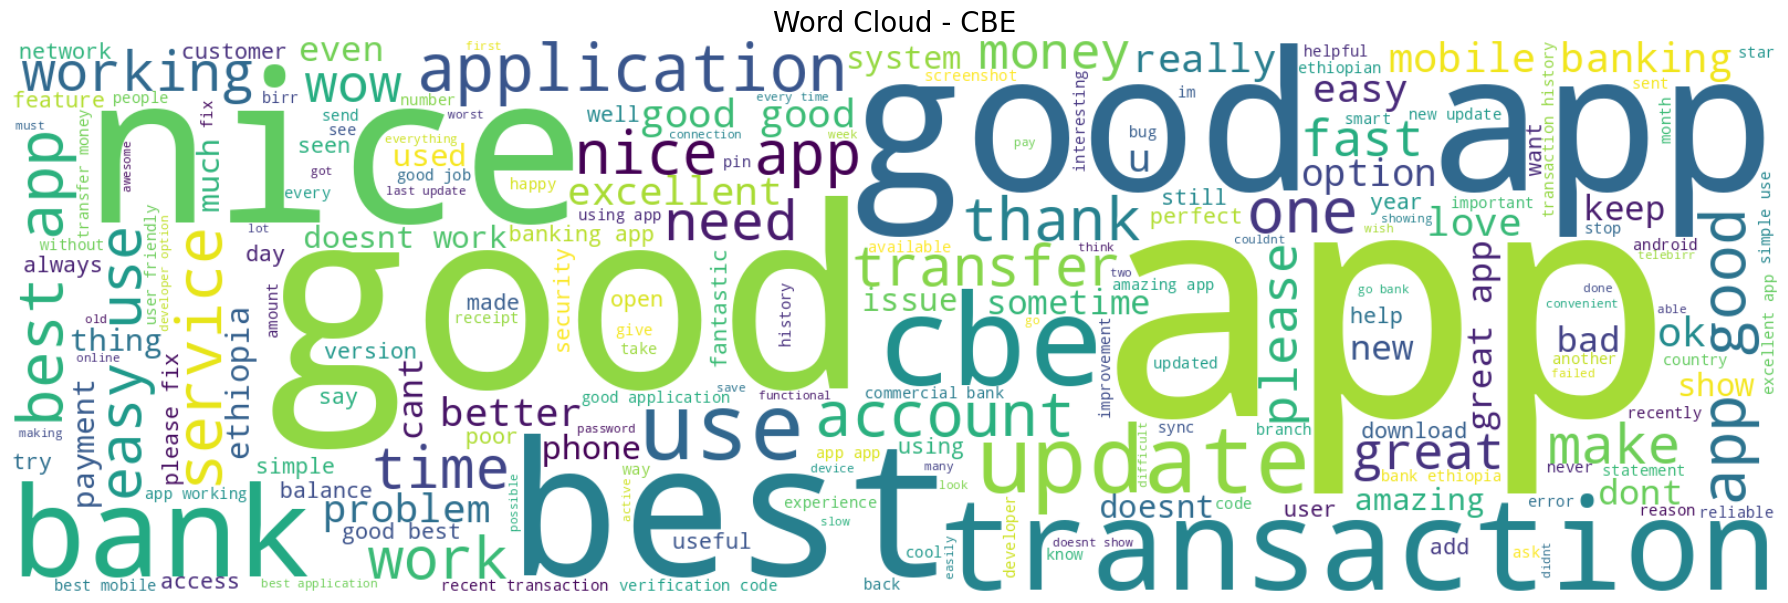


☁️ The word cloud above shows key themes in reviews for CBE.



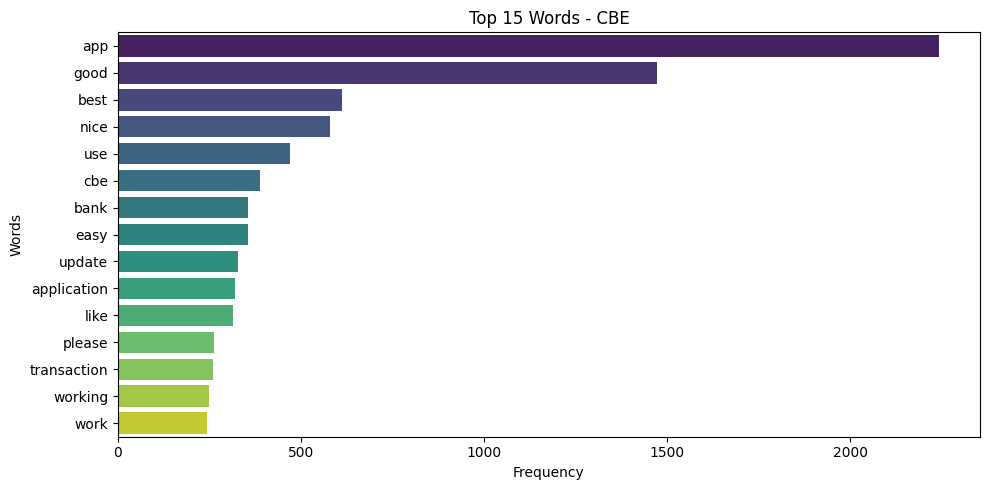


📌 Top 15 most frequent words in reviews from CBE.


📌 --- Summary for Bank: Dashen ---
Total Reviews: 448
Average Rating: 4.48
Max Review Length: 500
Reviews per Day (Mean): 3.8290598290598292
Sentiment Breakdown:
sentiment
positive    333
neutral      98
negative     17
Name: count, dtype: int64
─────────────────────────────


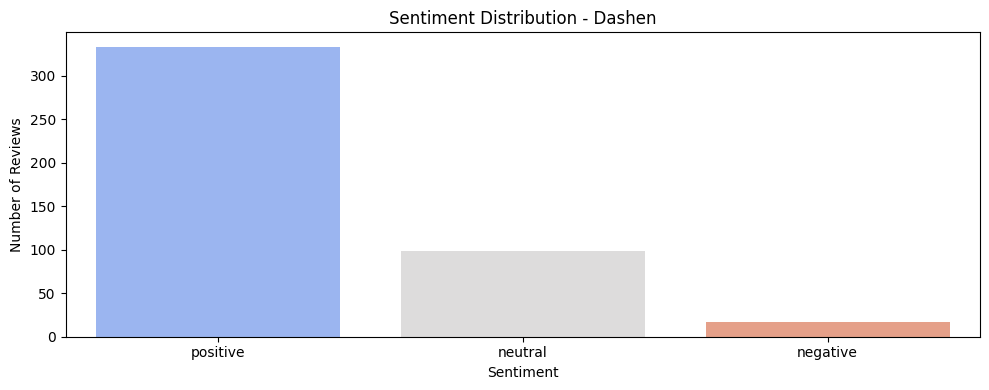


📊 Sentiment breakdown for Dashen displayed above.



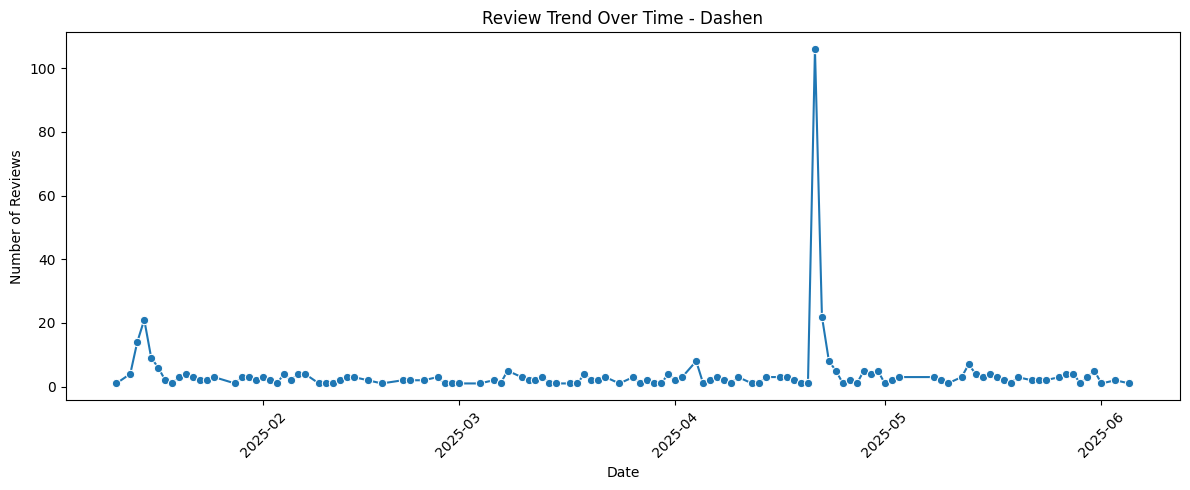


📈 Review trend over time for Dashen.



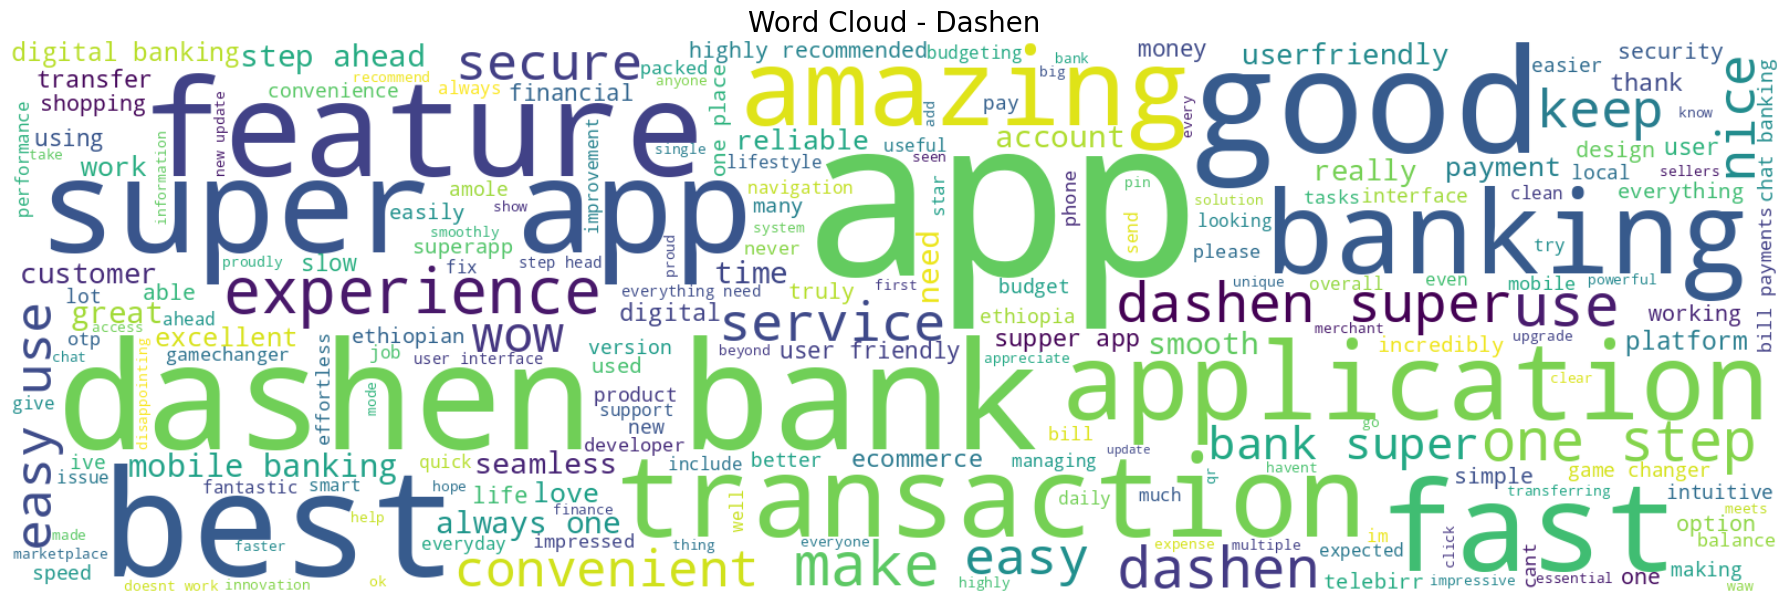


☁️ The word cloud above shows key themes in reviews for Dashen.



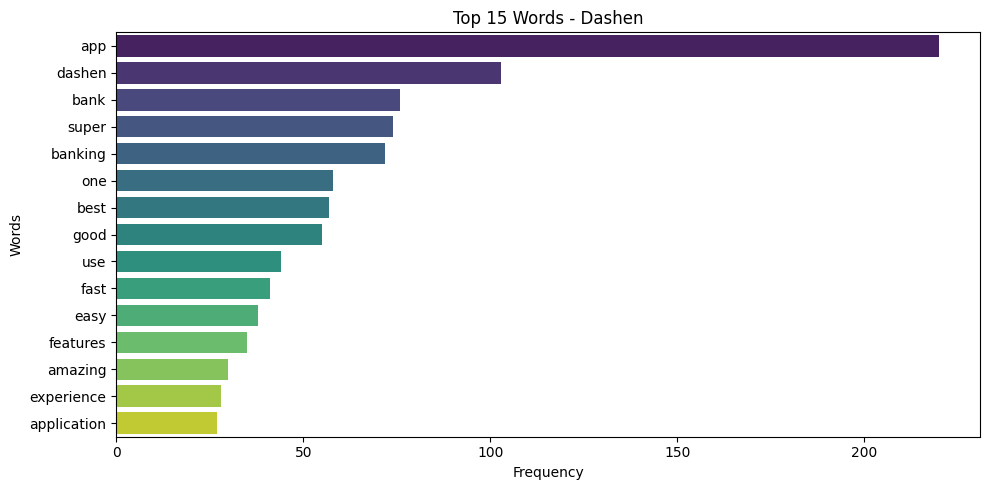


📌 Top 15 most frequent words in reviews from Dashen.


✅ Completed detailed analysis for all banks.



In [24]:
if __name__ == "__main__":
    analyzer = ReviewTextAnalyzer("/content/drive/MyDrive/kaim 6/week2/clean_reviews_translated.csv")
    analyzer.load_and_clean()
    analyzer.show_missing_values()
    analyzer.show_rows_with_missing()
    analyzer.run_full_analysis()

